## Finding entity classes in embeddings

In this notebook we're going to use embeddings to find entity classes and how they correlate with other things

In [1]:
%matplotlib inline

from sklearn import svm
import os
from keras.utils import get_file
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
import subprocess
import numpy as np
import random
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(12, 8)
import csv

Using TensorFlow backend.


In [5]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
if not os.path.isdir('generated'):
    os.mkdir('generated')
    
unzipped = os.path.join('generated', path)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zipper = subprocess.Popen(['7zip'],
                          stdin=open(path),
                          stdout=fout
                         )
        zipper.wait()

In [6]:
path

'C:\\Users\\GAO\\.keras\\datasets\\GoogleNews-vectors-negative300.bin.gz'

In [7]:
unzipped

'C:\\Users\\GAO\\.keras\\datasets\\GoogleNews-vectors-negative300.bin.gz'

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

In [4]:
model.most_similar(positive=['Germany'])

[('Austria', 0.7461062073707581),
 ('German', 0.7178748846054077),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868600845337),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437496542930603),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.6342948079109192)]

No we'll create a training set with countries and non countries and get a support vector machine to learn the difference.

In [5]:
countries = list(csv.DictReader(open('data/countries.csv')))
countries[:15]

[OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
 OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')]),
 OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
 OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
 OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')]),
 OrderedDict([('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')]),
 OrderedDict([('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')]),
 OrderedDict([('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')]),
 OrderedDict([('name', 'Netherlands'), ('cc', 'nl'), ('cc3', 'nld')]),
 OrderedDict([('name', 'East_Timor'), ('cc', 'tl'), ('cc3', 'tls')]),
 OrderedDict([('name', 'Tanzania'), ('cc', 'tz'), ('cc3', 'tza')]),
 OrderedDict([('name', 'Monaco'), ('cc', 'mc'), ('cc3', 'mco')]),
 OrderedDict([('name', 'Svalbard'), ('cc', 'sj'), ('cc3', 'sjm')]),
 OrderedDict([('name', 'Tajikistan'), ('cc', 'tj'), ('cc3', 'tjk')]),
 OrderedDict([('name', 'Turkey'), ('cc',

In [6]:
positive = [x['name'] for x in random.sample(countries, 40)]
negative = random.sample(model.vocab.keys(), 5000)
negative[:4]

['attorney_Nuris_Pinero',
 'Noble_fir',
 'Johns_Hopkins_Wilmer_Eye',
 'Romain_Feillu']

In [7]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
X.shape, y.shape

((5040, 300), (5040,))

In [8]:
TRAINING_FRACTION = 0.7
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off]) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [9]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(99.86772486772487, [('______tag', 0), ('Honduran', 0)])

In [10]:
all_predictions = clf.predict(model.vectors)

In [11]:
res = []
for word, pred in zip(model.index2word, all_predictions):
    if pred:
        res.append(word)
        if len(res) == 150:
            break
random.sample(res, 10)

['Vietnam',
 'Yemen',
 'Malaysia',
 'Korean',
 'country',
 'Sudanese',
 'continent',
 'Russia',
 'Nepal',
 'UK']

In [12]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape

(184, 300)

Quick sanity check to see what is similar to Canada:

In [13]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(idx, '-', countries[idx]['name'], dists[idx])

0 - Canada 7.544024
162 - New_Zealand 3.9619699
27 - Finland 3.9392405
134 - Puerto_Rico 3.838145
100 - Jamaica 3.8102937
125 - Sweden 3.8042789
17 - Slovakia 3.7038739
41 - Australia 3.671101
37 - Bahamas 3.6240416
23 - United_States 3.537434


Ranking countries for a specific term:

In [14]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [23]:
rank_countries('IKEA')

[('Sweden', 3.0974926948547363),
 ('Denmark', 2.886725902557373),
 ('Slovakia', 2.818697929382324),
 ('Latvia', 2.6764137744903564),
 ('Finland', 2.6145339012145996),
 ('Iceland', 2.550057888031006),
 ('Estonia', 2.517550230026245),
 ('Czech_Republic', 2.2646093368530273),
 ('Poland', 2.2366135120391846),
 ('Slovenia', 2.1979615688323975)]

Now let's visualize this on a world map:

In [195]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


We can now plot some maps!

In [196]:
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

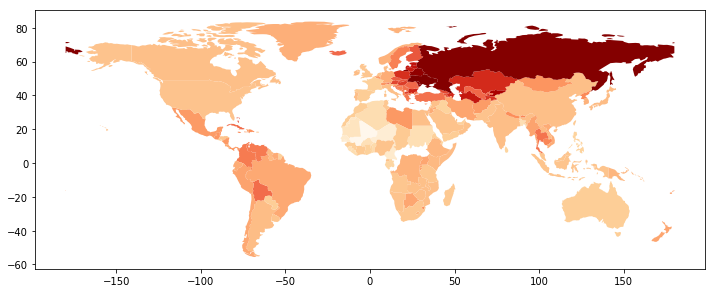

In [197]:
map_term('vodka')

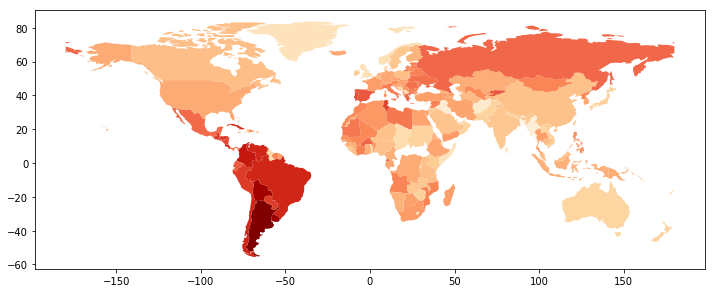

In [198]:
map_term('tango')

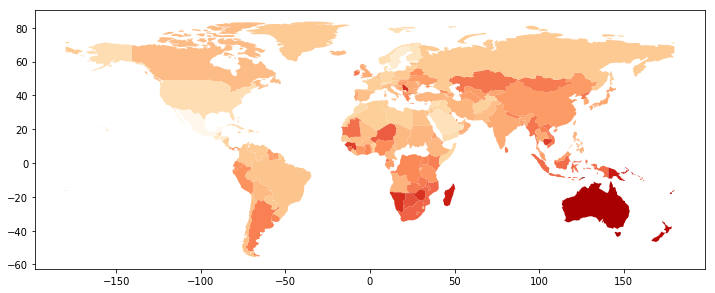

In [203]:
map_term('Kangaroo')